In [1]:
%load_ext autoreload
%autoreload 2
from data_util import *
from metric_util import *
from train_util import *
from model import *

import torch 
import pickle
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.models import resnet18
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import GCL.losses as L
from GCL.models import DualBranchContrast
from GCL.eval import get_split, LREvaluator
import GCL.augmentors as A



In [2]:
'''
config = {
    # meta config
    'dataset_name': 'adult',
    'sens_name': 'gender',
    'conditional': False,
    'debias': False,
    'adversarial': False,
    # tunable config
    'batch_size': 1024*7,
    'hidden_dim': 240,
    'drop_prob': 0.2,
    'cond_temp': 1.0/200,
    'debias_temp': 1.0/30,
    'debias_ratio': 4,
    'lr': 0.00005,
    'tau': 0.1,
}
'''
config = {
    # meta config
    'dataset_name': 'adult',
    'sens_name': 'gender',
    'conditional': True,
    'debias': True,
    'adversarial': False,
    # tunable config
    'batch_size': 256 * 8,
    'hidden_dim': 240*5,
    'drop_prob': 0.2,
    'cond_temp': 1.0/80,
    'debias_temp': 1.0/80,
    'debias_ratio': 8,
    'lr': 0.0001,
    'tau': 0.1,
}


In [2]:
# config from ray trial
config = {'dataset_name': 'adult',
 'sens_name': 'gender',
 'conditional': True,
 'debias': True,
 'adversarial': False,
 'batch_size': 5120,
 'hidden_dim': 220,
 'drop_prob': 0.23526761349095193,
 'cond_temp': 1/400,
 'debias_temp': 0.05464262537638573,
 'debias_ratio': 3.5787353988820394,
 'lr': 6.778680409743423e-06,
 'tau': 0.1}

In [4]:
# config for celeba gender from ray
config = {'dataset_name': 'celeba', 'sens_name': 'gender', 'conditional': False, 'debias': False, 'adversarial': False, 'batch_size': 1024, 'hidden_dim': 200, 'drop_prob': 0.21933711406450526, 'cond_temp': 0.004580936862279113, 'debias_temp': 0.014837335160686837, 'debias_ratio': 5.895037428868658, 'lr': 0.00020992489648128816, 'tau': 0.050515329052622834}

In [3]:
# some more config setting
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

dataset_name = config['dataset_name']
sens_name = config['sens_name']
sens_num = 2 if sens_name=='gender' else 1
TASK_TYPE = 'regression' if dataset_name=='crimes' else 'classification'

In [4]:
# load dataset...
dataset = get_dataset(dataset_name, sens_name)
#x = dataset[:][0]
#sens = dataset[:][2]
sample_index = None
if dataset_name in ['pokecn', 'pokecz']:
    g, sens, sample_index = get_samples(dataset, num=5000)
else:
    g, sens = get_samples(dataset, num=5000)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=3)

In [5]:
# prepare model config
input_dim = dataset.input_dim #dataset[0][0].shape[-1]
hidden_dim = config['hidden_dim'] if dataset_name != 'celeba' else 1000
sens_dim = dataset.sens_dim

In [6]:
# create model
model_switcher = {
    'adult': MLP(input_dim, hidden_dim),
    'crimes': MLP(input_dim, hidden_dim),
    'celeba': RES(),
    'pokecn': GConv(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=3),
    'pokecz': GConv(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=3),
}
main_encoder = model_switcher[dataset_name]
sens_encoder = MLP(sens_dim,hidden_dim)
adv_model = Adv_sens(sens_num=sens_num, hidden_dim=hidden_dim)

aug_switcher = {
    'adult': FeatureDrop(drop_prob=config['drop_prob']),
    'crimes': FeatureDrop(drop_prob=config['drop_prob']),
    'celeba': transforms.Compose([transforms.RandomCrop(size=RESIZE), transforms.ColorJitter(),
                         transforms.Grayscale(num_output_channels=3), transforms.RandomHorizontalFlip(),
                         transforms.RandomVerticalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    'pokecn': A.Compose([A.EdgeAdding(config['drop_prob']), A.EdgeRemoving(config['drop_prob']), A.FeatureMasking(config['drop_prob'])]),
    'pokecz': A.Compose([A.EdgeAdding(config['drop_prob']), A.EdgeRemoving(config['drop_prob']), A.FeatureMasking(config['drop_prob'])]),
}
aug = aug_switcher[dataset_name]

encoder_model = Encoder(main_encoder = main_encoder, augmentor = aug, sens_encoder = sens_encoder, adv_model=adv_model)
encoder_model = encoder_model.to(device)

In [8]:
contrast_model = DualBranchContrast(loss=L.FairInfoNCE(tau=config['tau']), mode='G2G').to(device)
optim = Adam(encoder_model.parameters(), lr=config['lr'])

performance_list = []
hist_gdp_list = []
max_gdp_list = []
kernel_gdp_list = []

(epoch_num,interval) = (500,50) if dataset_name!='celeba' else (10,1)

with tqdm(total=epoch_num, desc='(T)') as pbar:
    for epoch in range(1, epoch_num+1):
        encoder_model = encoder_model.to(device)
        loss_result = train(encoder_model = encoder_model, contrast_model=contrast_model,
                                         dataloader=dataloader, optimizer = optim,
                                         conditional=config['conditional'],debias=config['debias'], adversarial=config['adversarial'] if epoch%5==0 else False,
                                         cond_temp = config['cond_temp'],
                                         debias_temp = config['debias_temp'],
                                         debias_ratio = config['debias_ratio'])
        pbar.set_postfix({'loss': loss_result['loss'], 
                          'conditional_loss':loss_result['conditional_loss'], 
                          'debias_loss': loss_result['debias_loss'],
                          'adv_loss': loss_result['adv_loss']})
        pbar.update()

        if epoch % interval == 0:
            print(loss_result)
            result, evaluator = test(encoder_model, dataloader, evaluator=LREvaluator(task=TASK_TYPE))
            #result, evaluator = test(encoder_model, dataloader, evaluator=SVMEvaluator())
            classifier = result['classifier']
            
            # performance 
            performance = result['mae'] if dataset_name=='crimes' else result['auc']
            print('performance: ', performance)
            performance_list.append(performance)

            # fairness
            gdp_hist, gdp_kernel, gdp_max = gdp(g=g, sens=sens, sample_index=sample_index, task=TASK_TYPE, hist_num=1000, encoder_model=encoder_model, classifier=classifier)
            print('hist gdp: ', gdp_hist)
            hist_gdp_list.append(gdp_hist)
            print('max gdp: ', gdp_max)
            max_gdp_list.append(gdp_max)
            print('kernel gdp: ', gdp_kernel)
            kernel_gdp_list.append(gdp_kernel)
            #print(' auc: ', result['auc'], ' dp: ', dp)

(T):  10%|█         | 50/500 [00:59<08:53,  1.19s/it, loss=1.66, conditional_loss=1.63, debias_loss=0.00384, adv_loss=0]

{'loss': 1.6589776458947554, 'conditional_loss': 1.628242534139882, 'debias_loss': 0.003841889621900902, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:11<00:00, best test F1Mi=0.847, F1Ma=0.787]


performance:  0.770897655803316
hist gdp:  0.06108199999999997
max gdp:  0.13590751115837996
kernel gdp:  0.053698458


(T):  20%|██        | 100/500 [02:12<08:06,  1.22s/it, loss=1.55, conditional_loss=1.53, debias_loss=0.0032, adv_loss=0]

{'loss': 1.5519660296647444, 'conditional_loss': 1.5264058890550032, 'debias_loss': 0.003195017365887116, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:10<00:00, best test F1Mi=0.851, F1Ma=0.786]

performance:  0.7698691280984573
hist gdp:  0.06508199999999997
max gdp:  0.14480751516338186
kernel gdp:  0.05721494



(T):  30%|███       | 150/500 [03:24<07:03,  1.21s/it, loss=1.47, conditional_loss=1.44, debias_loss=0.0032, adv_loss=0] 

{'loss': 1.4673312345276708, 'conditional_loss': 1.4417235799457715, 'debias_loss': 0.0032009561695553637, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:11<00:00, best test F1Mi=0.843, F1Ma=0.771]

performance:  0.7512791980455349
hist gdp:  0.06244600000000006
max gdp:  0.13894241252408568
kernel gdp:  0.05489759



(T):  40%|████      | 200/500 [04:37<06:11,  1.24s/it, loss=1.42, conditional_loss=1.4, debias_loss=0.00277, adv_loss=0] 

{'loss': 1.421138557402984, 'conditional_loss': 1.3989576412283855, 'debias_loss': 0.002772615577154995, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:11<00:00, best test F1Mi=0.835, F1Ma=0.766]

performance:  0.747437046747537
hist gdp:  0.06298999999999999
max gdp:  0.1401528130687658
kernel gdp:  0.055375837



(T):  50%|█████     | 250/500 [05:50<04:57,  1.19s/it, loss=1.37, conditional_loss=1.35, debias_loss=0.00219, adv_loss=0]

{'loss': 1.3678033960902172, 'conditional_loss': 1.3503180198047473, 'debias_loss': 0.0021856730318078285, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:10<00:00, best test F1Mi=0.848, F1Ma=0.78]

performance:  0.7609763039755635
hist gdp:  0.054169999999999996
max gdp:  0.12052830423773686
kernel gdp:  0.047621988



(T):  60%|██████    | 300/500 [07:01<03:52,  1.16s/it, loss=1.34, conditional_loss=1.32, debias_loss=0.00239, adv_loss=0]

{'loss': 1.3424101977244667, 'conditional_loss': 1.3232687335947286, 'debias_loss': 0.002392683191831212, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:10<00:00, best test F1Mi=0.851, F1Ma=0.789]

performance:  0.7708447169773137
hist gdp:  0.05362600000000006
max gdp:  0.11931790369305662
kernel gdp:  0.04714374



(T):  70%|███████   | 350/500 [08:13<02:58,  1.19s/it, loss=1.32, conditional_loss=1.3, debias_loss=0.00247, adv_loss=0] 

{'loss': 1.3176306434299634, 'conditional_loss': 1.2978351712226868, 'debias_loss': 0.00247443417772724, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:11<00:00, best test F1Mi=0.854, F1Ma=0.78]

performance:  0.7596357245257384
hist gdp:  0.055580000000000074
max gdp:  0.12366555564949999
kernel gdp:  0.04886155



(T):  80%|████████  | 400/500 [09:26<02:05,  1.25s/it, loss=1.27, conditional_loss=1.26, debias_loss=0.00194, adv_loss=0]

{'loss': 1.2717168914235157, 'conditional_loss': 1.256165369697239, 'debias_loss': 0.0019439408877825253, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:10<00:00, best test F1Mi=0.847, F1Ma=0.776]

performance:  0.7543013996873353
hist gdp:  0.05167200000000005
max gdp:  0.11497025173661324
kernel gdp:  0.045425933



(T):  90%|█████████ | 450/500 [10:38<01:02,  1.25s/it, loss=1.26, conditional_loss=1.25, debias_loss=0.0014, adv_loss=0] 

{'loss': 1.2647836713687233, 'conditional_loss': 1.2535590270291204, 'debias_loss': 0.001403081257735202, 'adv_loss': 0.0}


(LR): 100%|██████████| 5000/5000 [00:11<00:00, best test F1Mi=0.85, F1Ma=0.778]

performance:  0.7583734682297149
hist gdp:  0.05007800000000001
max gdp:  0.11142360014062003
kernel gdp:  0.04402462



(T): 100%|██████████| 500/500 [11:51<00:00,  1.20s/it, loss=1.25, conditional_loss=1.24, debias_loss=0.00205, adv_loss=0]

{'loss': 1.2516298734623452, 'conditional_loss': 1.2352505054162897, 'debias_loss': 0.002047421606919846, 'adv_loss': 0.0}


(T): 100%|██████████| 500/500 [12:02<00:00,  1.45s/it, loss=1.25, conditional_loss=1.24, debias_loss=0.00205, adv_loss=0]

performance:  0.7508149560081028
hist gdp:  0.05016999999999999
max gdp:  0.11162830023273507
kernel gdp:  0.044105504


In [9]:
ray_result = torch.load('adult_age_ray_config_result')

In [10]:
x, sens = get_samples(dataset, num=5000)

In [11]:
sum(sens.numpy())

array([104], dtype=uint8)

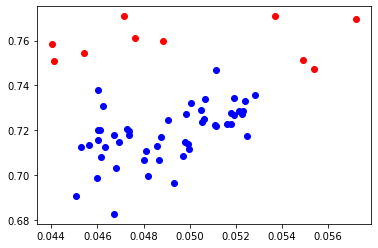

In [12]:
plt.scatter(kernel_gdp_list, performance_list, color = 'red')
plt.scatter(ray_result['kernel_gdp_list'], ray_result['performance_list'], color = 'blue')

In [ ]:
(T):  10%|█         | 1/10 [02:56<26:26, 176.33s/it, loss=3.31, conditional_loss=3.31, debias_loss=0, adv_loss=0]{'loss': 3.3105884914128287, 'conditional_loss': 3.3105884914128287, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.722, F1Ma=0.627]
performance:  0.6215321238170274
hist gdp:  0.017824879999999987
max gdp:  0.036591183832224816
kernel gdp:  0.01747832
(T):  20%|██        | 2/10 [06:49<27:58, 209.78s/it, loss=1.2, conditional_loss=1.2, debias_loss=0, adv_loss=0]  {'loss': 1.2037508939422152, 'conditional_loss': 1.2037508939422152, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.724, F1Ma=0.626]
performance:  0.6197896351154141
hist gdp:  0.003113199999999927
max gdp:  0.006390824146164431
kernel gdp:  0.0030526735
(T):  30%|███       | 3/10 [10:41<25:40, 220.06s/it, loss=0.602, conditional_loss=0.602, debias_loss=0, adv_loss=0]{'loss': 0.6021230984596336, 'conditional_loss': 0.6021230984596336, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.723, F1Ma=0.629]
performance:  0.6226530693897584
hist gdp:  0.00046783999999994164
max gdp:  0.0009603890429594752
kernel gdp:  0.00045875457
(T):  40%|████      | 4/10 [14:34<22:30, 225.06s/it, loss=0.365, conditional_loss=0.365, debias_loss=0, adv_loss=0]{'loss': 0.3646215566861554, 'conditional_loss': 0.3646215566861554, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.721, F1Ma=0.609]
performance:  0.607438862026335
hist gdp:  0.004117119999999974
max gdp:  0.00845168633838378
kernel gdp:  0.0040370813
(T):  50%|█████     | 5/10 [18:28<19:01, 228.29s/it, loss=0.247, conditional_loss=0.247, debias_loss=0, adv_loss=0]{'loss': 0.24697424630698916, 'conditional_loss': 0.24697424630698916, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.726, F1Ma=0.64]
performance:  0.6320688959634982
hist gdp:  0.017640800000000012
max gdp:  0.03621330161816033
kernel gdp:  0.017297806
(T):  60%|██████    | 6/10 [22:26<15:25, 231.41s/it, loss=0.195, conditional_loss=0.195, debias_loss=0, adv_loss=0]{'loss': 0.19505906526772482, 'conditional_loss': 0.19505906526772482, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.719, F1Ma=0.602]
performance:  0.6024729446223019
hist gdp:  0.021214320000000023
max gdp:  0.04354907763730498
kernel gdp:  0.020801848
(T):  70%|███████   | 7/10 [26:19<11:36, 232.03s/it, loss=0.156, conditional_loss=0.156, debias_loss=0, adv_loss=0]{'loss': 0.15644739872816973, 'conditional_loss': 0.15644739872816973, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.719, F1Ma=0.596]
performance:  0.5965043916591223
hist gdp:  0.010264080000000002
max gdp:  0.02107025899465595
kernel gdp:  0.010064515
(T):  80%|████████  | 8/10 [30:11<07:44, 232.18s/it, loss=0.141, conditional_loss=0.141, debias_loss=0, adv_loss=0]{'loss': 0.1410486141465745, 'conditional_loss': 0.1410486141465745, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.716, F1Ma=0.59]
performance:  0.5926175157903203
hist gdp:  0.013655040000000007
max gdp:  0.0280312730787744
kernel gdp:  0.013389545
(T):  90%|█████████ | 9/10 [34:04<03:52, 232.49s/it, loss=0.122, conditional_loss=0.122, debias_loss=0, adv_loss=0]{'loss': 0.1224909244843249, 'conditional_loss': 0.1224909244843249, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.714, F1Ma=0.588]
performance:  0.5909408460459336
hist gdp:  0.027953040000000012
max gdp:  0.057382424190767944
kernel gdp:  0.027409546
(T): 100%|██████████| 10/10 [37:59<00:00, 233.14s/it, loss=0.111, conditional_loss=0.111, debias_loss=0, adv_loss=0]{'loss': 0.11095712408892014, 'conditional_loss': 0.11095712408892014, 'debias_loss': 0.0, 'adv_loss': 0.0}
(LR): 100%|██████████| 500/500 [00:04<00:00, best test F1Mi=0.715, F1Ma=0.588]
performance:  0.5911484300807217
hist gdp:  0.010051999999999998
max gdp:  0.0206348979562008
(T): 100%|██████████| 10/10 [38:56<00:00, 233.64s/it, loss=0.111, conditional_loss=0.111, debias_loss=0, adv_loss=0]kernel gdp:  0.0098565575